# Experiments on downward accelearation axis


In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
path = r'D:\code\PyCharmProjects\thesis\data\trolli_playground\acc_data\acc_data.csv'
df = pd.DataFrame(pd.read_csv(path,sep=','))
df.columns = ['_time', 'acc_down']
df.head()


,_time,acc_down
0,59900520,-0.041439
1,59900529,-0.034107
2,59900540,-0.022742
3,59900549,-0.010080
4,59900559,0.001080


In [4]:
downs = df['acc_down'].tolist()
_time = df ['_time'].tolist()
length = len(_time) if len(_time) == len(downs) else print('PROBLEM')
length


10497

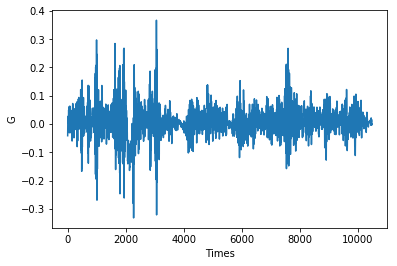

In [5]:
plt.plot(downs)
plt.xlabel('Times')
plt.ylabel('G')
plt.show()


##### What we wanna do now?

We have multiple requirements. 
First we want to represent the down values in Hz (frequency), rather than g force.
Then we would apply some techniques that can identify potholes.

Techniques like: 
- z threshold
- z diff
- std dev of windows
- maybe accounting all three axes.

Okay, let's say, we have used these techniques. What to do then?
Our priority number one is not just to have potholes extracted from a signal, relative to
other data points in the signal, but we have to know when that signal exactly happened.
It is important for us to know when that measurement exactly happened, so we can map these 
theoretical potholes back to the real world, that is represent them on a map.

We don't really have to know the exact position of accleration measurement or even the theoretical pothole,
as we have timestamps attached to both the acceleration signals and the points of the gps track.
Mapping back to the physical world then only requires that we know the exact timestamp of a accleration measurement.

But first let us investigate the properies of out signal.
Okay. Let's start off with something very simple. 
When we drive over a pothole happens it's a high energy event, which is represented by
high and/or low peaks in the acc data.

Let's just count the average of the signal first.

Note: the values of the acceleration singal is in G (9.81m/s^2)


In [6]:
avg = sum(downs)/length
avg


0.00664729630103349

So as we can see the avg is very close to 0 which is what we expect anyway.
Let's have the standard deviation of our signal as well.


In [7]:
std = np.std(downs)
std


0.048615364336357755

Okay. Not a very useful piece of information, but let's go on. Later std dev will have a central role.

Let's find the max and min of the signal.


In [8]:
max_value = max(downs)
min_value = min(downs)
print('max: ',max_value)
print('min: ',min_value)


max:  0.3666001017350895
min:  -0.33183568220156023


Now let's see how many measurements are between -0.1 and 0.1 Gs


In [9]:
min_threshold, max_threshold = (-0.1,0.1)
counter = 0
for d in downs:
    if min_threshold < d < max_threshold:
        counter+=1
print('From the total of {} measurements, {} are in between the min and max threshold.'.format(length, counter))


From the total of 10497 measurements, 9962 are in between the min and max threshold.


Now let's create a dummy pothole detection algorithm. We would assume that's everything
which has higher than 0.1G amplitude is a pothole.


In [10]:
min_threshold, max_threshold = (-0.1,0.1)
potholes = []
for d in downs:
    if min_threshold < d < max_threshold:
        potholes.append(0)
    else: 
        potholes.append(1)


Now let's plot this.


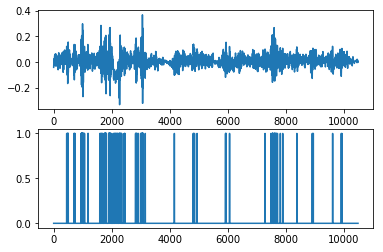

In [12]:
plt.subplot(211)
plt.plot(downs)
plt.subplot(212)
plt.plot(potholes)

plt.show()


The upper subplot is the filtered acceleration signal, and below we can see where the signal
has higher amplitudes than 0.1.

But this is really not the right way to do it. 

~~First of all we might have problems in the downs dataset. It didn't look like this before.~~
It was because I plotted the data against time, but there are timestamps, where no data is available.

So. How to proceed?
First, for the sake of clarity, let's assume these are the potholes we are looking for. 

Let's visualize these potholes on a real map.
For this I have to first load in the gps measurements that are already processed with 
a Multi Model Adaptive Kalman Filter.


In [13]:
path_of_gps = r'D:\code\PyCharmProjects\thesis\data\trolli_playground\kalmaned_data\kalmaned_data.csv'
path_of_intervals = r'D:\code\PyCharmProjects\thesis\data\trolli_playground\kalmaned_data\interval_data.csv'
gps_df = pd.DataFrame(pd.read_csv(path_of_gps,sep=','))
interval_df = pd.DataFrame(pd.read_csv(path_of_intervals,sep=','))
gps_df.columns = ['time', 'lng', 'lat']
interval_df.columns = ['prio', 'post']
gps_df.head()
# interval_df.head()


,time,lng,lat
0,59902000,735420.077995,102499.017416
1,59903000,735413.055012,102499.852677
2,59904000,735403.121753,102501.175136
3,59905000,735392.182963,102502.473503
4,59906000,735380.228327,102502.136988


Let's visualize it.


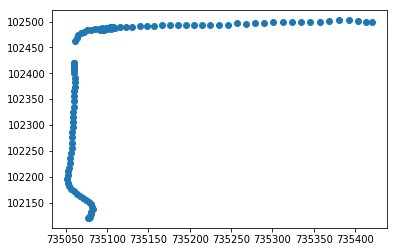

In [14]:
plt.scatter(gps_df['lng'], gps_df['lat'])
plt.show()


Okay we have the gps points of the track. For every point there we have a timestamp. 
And for every timestamp we have an interval in which we have acceleration measurements.

Note, that our GPS sensor has a temporal resolution of 1Hz, while our acceleration
sensor has a temporal resolution of 100Hz. So theoretically, for every point in the map, we have
100 measured accelearation values.
The intervals are position around the timestamps of gps measurements. An interval for
a gps measurement starts from t-0.5 sec and lasts until t+0.5sec.

So let's bring back out `potholes` list and append timestamps to it. Or whats better
recreate this potholes object in a way that we get the indices where a pothole happened.

So I'll first copy paste and edit the script that I wrote earlier.





In [15]:
potholes = []
for t, d in zip(_time, downs):
    if min_threshold < d < max_threshold:
        pass
    else: 
        potholes.append((t,1))
len(potholes)


535

Okay, let's see which pothole fits in which interval.


In [16]:
prios, posts = interval_df['prio'], interval_df['post']
indices = []
for i, (pr, po) in enumerate(zip(prios,posts)):
    for t,_ in potholes:
        if pr < t < po:
            indices.append(i)
set_of_indices = set(indices)
print(len(set_of_indices))
print(set_of_indices)
    

36
{3, 5, 6, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 39, 46, 47, 57, 58, 70, 72, 73, 74, 75, 76, 81, 86, 93, 96}


36 36


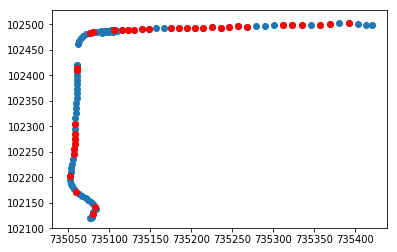

In [23]:
gps_time = gps_df['time'].tolist()
lng = gps_df['lng'].tolist()
lat = gps_df['lat'].tolist()
type(gps_time)
lngs = []
lats = []
for i in list(set_of_indices):
    lngs.append(lng[i])
    lats.append(lat[i])
print(len(lngs), len(lats))
plt.scatter(gps_df['lng'], gps_df['lat'])
plt.scatter(lngs, lats, color="red")
plt.show() 


Yooo! This looks cool however it's fake as hell probably :):)

Now let's discuss what's wrong with this, and how to proceed.

First of all what we've done above is ignoring many things. We got 535 acceleration measurements
that has higher amplitude than our threshold of 0.1 and we checked which time interval 
contains these out-of-threshold acceleration measurements. But we didn't check how many 
measurements are in a single interval. So if only one acceleration measurement goes beyond the threshold,
we handle it the same as if all the 100 acceleration measurements go beyond the threshold.

Second of all the bare threshold is not the best method to select acceleration measurements
to be potholes. There might be quite a long set of measurements in a specific time interval 
that are really close to zero, and then one of the measurements go beyond 0.1 with only as little as
0.000001 aplitude, and then we declare, that whole set of acceleration measurements in that interval
is a pothole. Bullshit!

Then there we have another problem. It's okay that we have these so-called intervals, that is
1 sec window around a gps measurement, but to be honest it's just thoretical. The acceleration 
measurements are still in one huge stream of data, which we process, and apply the intervals 
afterward. This totally ignores the fact that the boundaries of these time intervals can and will
split a pothole event into two parts, so we would classify both gps points as potholes,
but this isn't always the best solution.

There a few more bad aspects of the method above. But let's see how we could 
improve our model.

Maybe the least we could do is apply a windowing function to our data. That is
split the dataset into overlapping segments. This way not only we analyze one part of the
dataset at time,which can lead to improved results, but we would also be able to recognize
potholes that are on the boundary of two time intervals due to the fact that the 
segments overlap.

So let's window our data. We'll introduce some functions here first.


In [26]:
def do_windowing(axis, hamming=False, window_size=100):
    n = window_size
    m = round(n / 4)  # overlap_size
    if hamming == False:
        windows = [axis[i:i + n] for i in range(0, len(axis), n - m)]
    else:
        windows = [do_hamming(axis[i:i + n], n) for i in range(0, len(axis), n - m)]
    return windows


def do_hamming(dataset, n):
    window = np.hamming(n)
    if len(dataset) != n: window = np.hamming(len(dataset))
    windowed_data_og = np.multiply(dataset, window)
    return windowed_data_og


Now this was already written in the meantime of some earlier experiments.
I'll split both the acceleration measurement timestamps and downward acceleration 
to segments, but will only apply hamming window function to the latter.


In [31]:
windowed_acc_time = do_windowing(_time)
windowed_acc_down = do_windowing(downs, hamming=True)
print(len(windowed_acc_time), len(windowed_acc_down))
print(windowed_acc_time[0][75:85])
print(windowed_acc_time[1][0:10])
print(windowed_acc_down[0][75:86])
print(windowed_acc_down[1][0:10])  


140 140
[59901255, 59901265, 59901276, 59901285, 59901295, 59901304, 59901314, 59901324, 59901334, 59901344]
[59901255, 59901265, 59901276, 59901285, 59901295, 59901304, 59901314, 59901324, 59901334, 59901344]
[0.03094056 0.02674949 0.02330577 0.02125777 0.02049122 0.02027692
 0.01965858 0.01788658 0.01470859 0.01042351 0.00571334]
[0.00477743 0.00442673 0.00423955 0.0043502  0.00481242 0.00555529
 0.00636398 0.00690811 0.0068248  0.00583892]


There is a difference of course.
Timestamps didn't go through a windowing function, it just got split up.
But now we have the windows. What to do with them?
In our work we want to acquire potholes, and for that we will use techniques 
listed above.

First Z-threshold properly.
Second Z-diff.
Third Z-stddev.


In [32]:
min_threshold, max_threshold = (-0.08,0.08)
indices_of_high_amplitude_measurements = []
for window in windowed_acc_down:
    indices_in_window=[]
    for i, down in enumerate(window):
        if min_threshold < down < max_threshold:
            pass
        else: 
            indices_in_window.append(i)
    if len(indices_in_window) >= 5:
        indices_of_high_amplitude_measurements.append(indices_in_window)
    else:
        indices_of_high_amplitude_measurements.append([])

    

Ok, we will not map these into real world now. Let's just go ahead and
write some implementation for the other two techniques.

Z-diff can be implemented two ways it seems.
- First: the absolute difference between the highest and lowest value.
- Second: we have a point, we loop further until a peak is reached,
that is at some point the next measurement would be lower 
(or higher in case if we go over a low peak or valley) than the prior one.
Then we measure whats the difference between point to peak or peak to peak.

The above two are almost the same. The first is a lot easier to implement
but it will get the diff from the absolute highest and the absolute 
lowest values, disregarding if they are neighbouring peaks or not.

So let's implement that.


In [39]:
diffs = []
potholes_by_z_diff = []
for i,window in enumerate(windowed_acc_down):
    max_val = max(window)
    min_val = min(window)
    diff = max_val - min_val
    diffs.append(diff)
    if diff > 0.16:
        potholes_by_z_diff.append(i)
potholes_by_z_diff
# np.average(diffs)
 

[6,
 9,
 12,
 13,
 15,
 21,
 23,
 25,
 26,
 30,
 32,
 37,
 40,
 64,
 80,
 99,
 100,
 101,
 102,
 118]

Was simple was simple. Now let's calculate the std devs the same way.


In [38]:
std_devs = []
potholes_by_z_stddev = []
for i,window in enumerate(windowed_acc_down):
    std = np.std(window)
    std_devs.append(std)
    if std > 0.04:
        potholes_by_z_stddev.append(i)
potholes_by_z_stddev



[6, 9, 12, 13, 21, 22, 23, 25, 27, 28, 30, 37, 40, 100, 101]